# Dataset

The dataset includes 5000 movies details scraped from IMDB website. The information of movies in dataset will be used to train model to predict the successful of a new movie before its release. Included factors are:
- director_name: Name of the director
- Budget of the movie
- Genre of the movie
- Original language the movie is in
- Casts in the movie and many more...

In [1]:
import plotly.graph_objects as go
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

init_notebook_mode(connected=True)
cf.go_offline(connected=True)
cf.set_config_file(theme="pearl")
#pd.set_option('display.max_columns', 30)
%matplotlib inline

In [2]:
import itertools
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [3]:
data = pd.read_csv("movie_metadata.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

The initial data have 5043 row with 28 columns with types described as above.

# Cleaning
## Remove duplicates:

In [4]:
data.drop_duplicates(keep='first', inplace = True)

## Examine genre column

This column contains genres of movie. A movie can be tagged with different genres, therefore, we need to process the data in this column first. 

In [5]:
data["genres"].head()

0    Action|Adventure|Fantasy|Sci-Fi
1           Action|Adventure|Fantasy
2          Action|Adventure|Thriller
3                    Action|Thriller
4                        Documentary
Name: genres, dtype: object

In [6]:
genres = list(itertools.chain(*data.genres.apply(lambda x: x.split("|"))))
print(f'there are {len(set(genres))} genres in the dataset which are: {set(genres)}')

there are 26 genres in the dataset which are: {'Action', 'Sci-Fi', 'War', 'Crime', 'Thriller', 'Romance', 'Fantasy', 'Mystery', 'Family', 'Comedy', 'Adventure', 'History', 'Biography', 'Musical', 'Short', 'Documentary', 'Western', 'News', 'Horror', 'Game-Show', 'Animation', 'Music', 'Sport', 'Film-Noir', 'Drama', 'Reality-TV'}


There are some duplicate in genre such as "Music" and "Musical" need to be remove. Besides, "Reality-TV", "Game-Show" and "News" will also be removed since they are not a movie genre.

In [7]:
data.genres = data.genres.str.replace("Musical", "Music")
genres = list(itertools.chain(*data.genres.apply(lambda x: x.split("|"))))
genres = [genre for genre in genres if genre not in ["Reality-TV","Game-Show","News"]]
print(len(set(genres)))

22


We now have 22 genres. Let's plot mean IMDB score of each genre.

In [8]:
d = {}
for genre in set(genres):
    score = [imdb for genre_list, imdb in zip(data.genres.apply(lambda x: x.split("|")), data["imdb_score"]) if genre in genre_list]
    d[genre] = np.sum(score)

In [9]:
genres_mean = {}    
for genre in d.keys():    
    genres_mean[genre] = d[genre]/Counter(genres)[genre]

In [10]:
df = pd.DataFrame(
    [{"genre": genre, "mean IMDB": imbd} for genre, imbd in genres_mean.items()])
df.iplot(kind='bar', x="genre", y="mean IMDB")

There is not much difference between genres. Almost all the mean are in range of 6 - 8. Therefore, the genres column can be removed from the dataframe as it does not relate to the IMDB score.

In [11]:
data.drop(["genres"], axis = 1, inplace=True)

## Missing value

As in above table, the number of value count for each column are not the same, which indicates that there are several rows those are missing some of value we have to handle.

In [12]:
data.isnull().sum(axis = 0).sort_values(ascending=False)

gross                        874
budget                       487
aspect_ratio                 327
content_rating               301
plot_keywords                152
title_year                   107
director_name                103
director_facebook_likes      103
num_critic_for_reviews        49
actor_3_name                  23
actor_3_facebook_likes        23
num_user_for_reviews          21
color                         19
duration                      15
facenumber_in_poster          13
actor_2_name                  13
actor_2_facebook_likes        13
language                      12
actor_1_name                   7
actor_1_facebook_likes         7
country                        5
cast_total_facebook_likes      0
num_voted_users                0
movie_title                    0
movie_imdb_link                0
imdb_score                     0
movie_facebook_likes           0
dtype: int64

<AxesSubplot:>

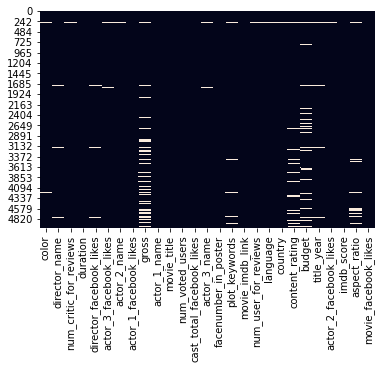

In [13]:
sns.heatmap(data.isnull(), cbar=False)

As we can see, "budget" and "gross" are columns with the most number of missing value. However, we can't either remove these two columns due the logically relation with the IMDB score or replace the missing values with mean of column. Therefore, the best solution is to remove rows with missing value.

In [14]:
data.dropna(subset = ["budget", "gross"], inplace=True)
print(len(data))

3857


The dataset has 3857 entries which is 77% of initial dataset. Let's take a look at other columns with missing values.

Before trying to impute the missing values, we want to measure how important three variables: aspect_ratio, content_rating, and plot_keywords which have the most missing value in the current dataset.

In [15]:
data["aspect_ratio"].value_counts()

2.35     1995
1.85     1600
1.37       50
1.78       41
1.66       40
1.33       19
2.39       11
2.20       10
2.40        3
2.76        3
2.00        3
1.75        2
2.24        1
1.18        1
2.55        1
1.77        1
16.00       1
1.50        1
Name: aspect_ratio, dtype: int64

the most common ratio are 2.35 and 1.85. To measure the importance of this variable, we will divide this variable into 3 groups:
- group 1 is 2.35
- group 2 is 1.85
- group 0 is other ratio

First we will replace missing value with 0 and then we will calculate the mean of IMDB score for each group.

In [16]:
#create a copy dataframe with only "aspect_ratio" and "imdb_score" for evaluation
temp_data = data[["aspect_ratio", "imdb_score"]].copy()

#fill n/a value
temp_data.fillna(0, inplace=True)

#catergorizing values into 3 groups and calculate mean of each group
temp_data["aspect_ratio"] = temp_data["aspect_ratio"].apply(lambda x: 1 if x==2.35 else 2 if x==1.85 else 0)
temp_data.groupby("aspect_ratio").mean()

,imdb_score
aspect_ratio,
0,6.672519
1,6.508471
2,6.373938


There is no significant different between these groups, therefore removing this variable won't affect the further analyzes

In [17]:
data.drop(["aspect_ratio"], axis = 1, inplace =True)

We further remove "plot_keywords" columns as it is considered as not related to the IMDB score analyze due to its diveristy.

In [18]:
data["plot_keywords"].nunique()

3759

In [19]:
data.drop(["plot_keywords"], axis = 1, inplace=True)

The last column with many missing values is "content_rating". We will examize its data

In [20]:
data["content_rating"].unique()

array(['PG-13', 'PG', 'G', 'R', 'Approved', 'NC-17', nan, 'X',
       'Not Rated', 'Unrated', 'M', 'GP', 'Passed'], dtype=object)

According to the rating system nowadays, it includes 5 ratings: PG-13, PG, NC-17, G, R. Therefore, we need to replace some old ratings with the new ones as following:
- M = GP = PG
- X = NC-17
- other ungrouped ratings such as: “Approved”, “Not Rated”, “Passed”, “Unrated” will be grouped as R

There is no suitable replacement for missing value for this column, therefore these rows will be remove from the dataset

In [21]:
#Remove rows with missing values
data.dropna(subset = ["content_rating"], inplace=True)

In [22]:
data["content_rating"].replace({"M":"PG","GP":"PG", "X":"NC-17", "Approved":"R","Not Rated":"R","Passed":"R", "Unrated":"R"}, inplace=True)
data["content_rating"].unique()

array(['PG-13', 'PG', 'G', 'R', 'NC-17'], dtype=object)

## Removing unrelated columns

**Is "Color" column relates to the IDMB score?**

In [23]:
data.color.value_counts()

Color               3680
 Black and White     124
Name: color, dtype: int64

96% of this column is color which indicates that this variable is nearly constant. Therefore, removing it will not affect the analyzing result.

In [24]:
data.drop(["color"], axis = 1, inplace=True)

Other columns with diverse values those are not useful for IDMB classification such as: "movie_title", "director_name", "actor_1_name", "actor_2_name", "actor_3_name" and "movie_imdb_link" will be removed from the dataset.

In [25]:
print(f'number of unique director name: {data["director_name"].nunique()}')
print(f'number of unique actor 1 name: {data["actor_1_name"].nunique()}')
print(f'number of unique actor 2 name: {data["actor_2_name"].nunique()}')
print(f'number of unique actor 3 name: {data["actor_3_name"].nunique()}')

number of unique director name: 1709
number of unique actor 1 name: 1473
number of unique actor 2 name: 2246
number of unique actor 3 name: 2646


In [26]:
data.drop(["movie_title","director_name", "actor_1_name", "actor_2_name", "actor_3_name", "movie_imdb_link"], axis = 1, inplace=True)

**How about "language" and "country"? Are they relevant in predicting IMDB?**

In [27]:
lang_count = data.language.value_counts()
lang_count_pct = lang_count*100/len(data)
fig = px.pie(lang_count_pct, values=lang_count_pct.values, names=lang_count_pct.index, title="Proportion for movie language")
fig.update_traces(hoverinfo='label+percent+value',textinfo='none')
fig.show()

95% of movie are in English, therefore, this variable is nearly constant. Let's remove it.

In [28]:
data.drop(["language"], axis = 1, inplace=True)

In [29]:
country_count = data.country.value_counts()
country_count_pct = country_count*100/len(data)
fig = px.pie(country_count_pct, values=country_count_pct.values, names=country_count_pct.index, title="Proportion for country")
fig.update_traces(hoverinfo='label+percent+value',textinfo='none')
fig.show()

Majority of movies come from USA (79%) and UK (8%), the rest 13% comes from other countries. Therefore, we will group other countries together to make this columns have few categories.

In [30]:
data.country = data.country.apply(lambda x: "Other" if x not in ["USA", "UK"] else x)

The rest missing values is insignificant in comparison to the dataset, therefore, these rows will be dropped.

In [31]:
data.isnull().sum(axis = 0).sort_values(ascending=False)

facenumber_in_poster         6
actor_3_facebook_likes       6
actor_2_facebook_likes       2
actor_1_facebook_likes       1
num_critic_for_reviews       1
content_rating               0
country                      0
num_user_for_reviews         0
imdb_score                   0
cast_total_facebook_likes    0
num_voted_users              0
gross                        0
budget                       0
title_year                   0
director_facebook_likes      0
duration                     0
movie_facebook_likes         0
dtype: int64

In [32]:
data.dropna(inplace=True)

Furthermore, the title_year is not really related to the IMDB score, therefore, this column will be dropped

In [33]:
data.drop("title_year", axis=1, inplace=True)

## Correlation check

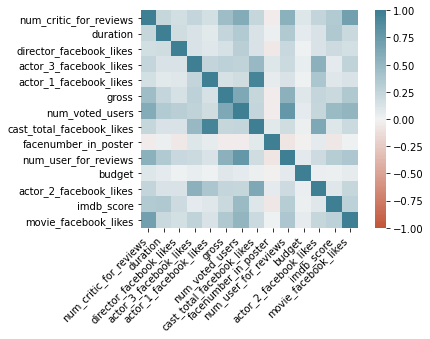

In [34]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Based on the heatmap, "actor_1_facebook_like", "actor_2_facebook_like" and "actor_3_facebook_like" are highly correlated with the "cast_total_facebook_likes". Therefore, we will remove these columns and only keep "cast_total_facebook_likes".

In [35]:
data.drop(["actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes"], axis=1, inplace=True)

There are also high correlation between "num_critic_for_reviews" and "num_user_for_reviews". We will take the ratio of these variable and remove them.

In [36]:
data["review_ratio"] = data["num_critic_for_reviews"] / data["num_user_for_reviews"]
data.drop(["num_critic_for_reviews","num_user_for_reviews"], axis=1, inplace=True)

The correlation heatmap now is:

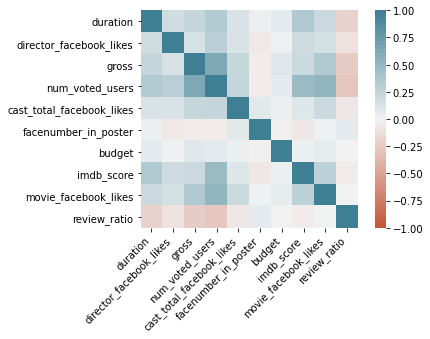

In [37]:
corr = data.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

It looks better and there is no high correlation between variables now. We now can separate the dataframe into features and target.

In [38]:
target = data["imdb_score"]
target.shape

(3793,)

In [39]:
features = data.drop("imdb_score", axis=1)
features.shape

(3793, 11)

# Preprocessing

There are several categorical features in the dataset, therefore, it is necessary to encode those features before fitting into a machine learning model.

## Encoding and scaling

Two categorical features: country and content_rating will be encoded using OneHotEncoder before fitting to any model. Besides, the data is mostly skewed and have outliers, RobustScaler will be used when scaling the data.

In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

#encoding the features dataframe
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), [6,7])], remainder='passthrough')
X = np.array(columnTransformer.fit_transform(features))

# rescale the data with RobustScaler to reduce the influence of outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(3793, 15)

Instead of having 11 features, we now have 15 features.

This classification part is aiming to predict the successful of a movie based on its IMDB, 7 is chosen to be the threshold to identify a good movie and a bad movie.

In [41]:
y = target.apply(lambda x: 1 if x>=7 else 0)

In [42]:
y.value_counts()

0    2505
1    1288
Name: imdb_score, dtype: int64

The number of sample for classes is a little bit skewed, therefore, we will use oversampling method with SMOTE to handle the imbalance.

## SMOTE for imbalance

In [43]:
from imblearn.over_sampling import SMOTE

X_smote,y_smote = SMOTE().fit_sample(X_scaled,y)

## Splitting into training, validating and testing set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=0.8, random_state=5)

#X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, train_size = 0.9, test_size = 0.2, random_state = 5)

#X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, train_size = 0.8, test_size = 0.2, random_state = 5)

print(f'Train set shape: {X_train.shape}, {y_train.shape}')
#print(f'Validation set shape: {X_val.shape}, {y_val.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Train set shape: (4008, 15), (4008,)
Test set shape: (1002, 15), (1002,)


# Model implementation
## Linear Classification

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

result = []
pipe = Pipeline([('classifier', LogisticRegression())])

param = [
    {'classifier':[LogisticRegression(n_jobs=-1, random_state=5)],
    'classifier__C':[0.0001,0.001,0.1,1,10,100]},
    {'classifier':[SGDClassifier(n_jobs=-1, random_state=5)],
    'classifier__alpha':[0.0001,0.001,0.1,1,10,100]}
]

grid = GridSearchCV(pipe, param_grid=param, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"LogisticRegression", "f1_score":grid.best_score_, "accuracy":accuracy_score(y_test, y_pred)})

Best params:
{'classifier': LogisticRegression(C=100, n_jobs=-1, random_state=5), 'classifier__C': 100}

Best cross-validation f1 score: 0.72

Confusion matrix: 
[[373 114]
 [174 341]]

accuracy score: 0.71


For linear classification, LogisticRegression performs is better than SGD at C=100, and the best accuracy it can achieve with testing set is 71%. However, based on the confusion matrix and classification report, there are still many misclassification for both classes. In general, f1-score for this model is only average. We will try linear classification with polynimial feature next to see if the performance is improved or not.

## Linear Classification with polynomial feature

Since when the degree of polynomial increases, the complexity also increases and so do the computation time and memory. Therefore, the degree of polynomial feature will be limited to 3.

In [46]:
from sklearn.preprocessing import PolynomialFeatures

print(f"With degree of 2")
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_smote)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y_smote, train_size=0.8, random_state=5)

pipe = Pipeline([('classifier', LogisticRegression())])

param = [
    {'classifier':[LogisticRegression(n_jobs=-1, random_state=5)],
    'classifier__C':[0.0001,0.001,0.1,1,10,100]},
    {'classifier':[SGDClassifier(n_jobs=-1, random_state=5)],
    'classifier__alpha':[0.0001,0.001,0.1,1,10,100]}
]

grid = GridSearchCV(pipe, param_grid=param, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"LogisticRegression with polynomial features", "f1_score":grid.best_score_, "accuracy":accuracy_score(y_test, y_pred)})

With degree of 2
Best params:
{'classifier': LogisticRegression(C=1, n_jobs=-1, random_state=5), 'classifier__C': 1}

Best cross-validation f1 score: 0.71

Confusion matrix: 
[[407  80]
 [194 321]]

accuracy score: 0.73


In [47]:
print(f"With degree of 3")
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_smote)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y_smote, train_size=0.8, random_state=5)

pipe = Pipeline([('classifier', LogisticRegression())])

param = [
    {'classifier':[LogisticRegression(n_jobs=-1, random_state=5)],
    'classifier__C':[0.0001,0.001,0.1,1,10,100]},
    {'classifier':[SGDClassifier(n_jobs=-1, random_state=5)],
    'classifier__alpha':[0.0001,0.001,0.1,1,10,100]}
]

grid = GridSearchCV(pipe, param_grid=param, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

With degree of 3
Best params:
{'classifier': LogisticRegression(C=0.0001, n_jobs=-1, random_state=5), 'classifier__C': 0.0001}

Best cross-validation f1 score: 0.70

Confusion matrix: 
[[207 280]
 [ 98 417]]

accuracy score: 0.62


For both degrees 2 and 3, LogisticRegression still perform better than SGD with different C. However, with degree of 2, the performance is similar to previous model, and number of misclassification case is still high, while it is even worse for the 3rd degree. The performance of model in polynomial degree of 3 is now only over 60%.

## SVC

In [48]:
from sklearn.svm import SVC

svc = SVC(random_state=5)

param = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(svc, param_grid=param, cv=5, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"SVC", "f1_score":grid.best_score_, "accuracy":accuracy_score(y_test, y_pred)})

Best params:
{'C': 100, 'gamma': 0.001}

Best cross-validation f1 score: 0.80

Confusion matrix: 
[[364 123]
 [ 77 438]]

accuracy score: 0.80


SVM with RBF kernel achieve 80% accuracy at C=100 and gamma of 0.001. We can also see the improvement in the misclassification case, but there are still many, which indicates a lot of room to improve further.


## Decision Tree Classification

In [49]:
X_dt = features.copy()
X_dt.country = X_dt.country.map({"USA":0, "UK":1, "Other":2})
X_dt["content_rating"] = X_dt["content_rating"].map({'PG-13':0, 'PG':1, 'G':2, 'R':3, 'NC-17':4})

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y, train_size=0.8, random_state=5)

In [75]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=5)

param = {'max_depth': [i for i in range(1,10)],
        'max_features': [i for i in range(1,X_train.shape[1])]}

grid = GridSearchCV(dt, param_grid=param, cv=5, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"Decision Tree", "f1_score":grid.best_score_, "accuracy":accuracy_score(y_test, y_pred)})

Best params:
{'max_depth': 8, 'max_features': 5}

Best cross-validation f1 score: 0.64

Confusion matrix: 
[[418  65]
 [101 175]]

accuracy score: 0.78


In [76]:
def plot_feature_importance(model,x,name):
    n_feature=x.shape[1]
    print(n_feature)
    plt.barh(range(n_feature),model.feature_importances_)
    plt.yticks(np.arange(n_feature),name)
    plt.xlabel("Feature importance")
    plt.ylabel("feature")

In [77]:
dt = DecisionTreeClassifier(max_depth=8, max_features=5, random_state=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_features=5, random_state=5)

11


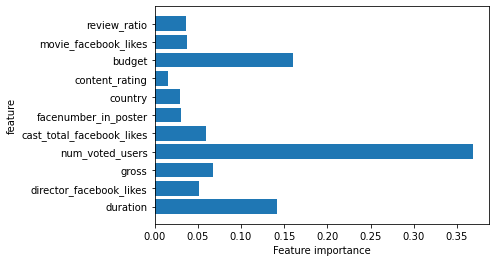

In [78]:
plot_feature_importance(dt,X_train,X_dt.columns)

With max_depth of 8 and max_features of 5, our DecisionTreeClassification reach 78% accuracy on testing set which is lower than SVC with RBF kernel. Among 11 features, all of them have impact on the result of decision tree. The number of voted user is the most important feature here.

## Ensemble Learning
### Voting classification

For voting classifier, previous models with their best parameters will be chosen as weak learners:
- LogisticRegression
- SVC with RBF kernel, C of 100, and gamma of 0.001
- and DecisionTreeClassifier with max_depth of 8, and max_features is 5.

#### Hard voting

In [79]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=0.8, random_state=5)

log_clf = LogisticRegression()
svc = SVC(kernel="rbf", C=100, gamma=0.001, probability=True)
dt = DecisionTreeClassifier(max_depth=8, max_features=5)

In [80]:
voting_clf = VotingClassifier(estimators=[('logr', log_clf), ('svc', svc), ('dt', dt)], voting='hard', n_jobs=-1)
score = cross_val_score(voting_clf, X_train, y_train, scoring="f1", n_jobs=-1, cv=5)

print(f"Average cross-validation f1 score with hard voting: {np.mean(score):.2f}\n")

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

Average cross-validation f1 score with hard voting: 0.76

Confusion matrix: 
[[381 106]
 [146 369]]

accuracy score: 0.75


#### Soft voting

In [81]:
voting_clf = VotingClassifier(estimators=[('logr', log_clf), ('svc', svc), ('dt', dt)], voting='soft', n_jobs=-1)
score = cross_val_score(voting_clf, X_train, y_train, scoring="f1", n_jobs=-1, cv=5)

print(f"Average cross-validation f1 score with soft voting: {np.mean(score):.2f}\n")

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"Voting classifier", "f1_score":np.mean(score), "accuracy":accuracy_score(y_test, y_pred)})

Average cross-validation f1 score with soft voting: 0.77

Confusion matrix: 
[[394  93]
 [131 384]]

accuracy score: 0.78


The result of hard and soft voting are still lower than previous decision tree and accuracy score for testing set is around 75% - 78%. We haven't improved anything.

### Bagging with SVC

Since SVC is the best model so far, we will try to use bagging method with SVC to see if the accuracy increase.

In [60]:
X_test.shape

(1002, 15)

In [62]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import f1_score

svc = SVC(kernel="rbf", C=100, gamma=0.001,probability=True)
bag_clf = BaggingClassifier(svc, n_estimators=100, max_features=14, n_jobs=-1, random_state=5, oob_score=True, bootstrap=True)

bag_clf.fit(X_train, y_train)
train_pred = bag_clf.predict(X_train)
print(f"f1 score on training set: {f1_score(y_train, train_pred):.2f}\n")

y_pred = bag_clf.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"SVC Bagging", "f1_score":f1_score(y_train, train_pred), "accuracy":accuracy_score(y_test, y_pred)})

f1 score on training set: 0.78

Confusion matrix: 
[[379 108]
 [140 375]]

accuracy score: 0.75


Surprisingly, implementing SVC with bagging doesn't increase the accuracy on overall. Number of classification case is still high and the accuracy doesn't reach 80%

### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_dt, y, train_size=0.8, random_state=5)
rf = RandomForestClassifier(n_jobs=-1, random_state=5, class_weight="balanced")

param = {'n_estimators': [100,200,300],
        'max_depth': [i for i in range(1,10)],
        'max_features': [i for i in range(1,X_train.shape[1])]}

grid = GridSearchCV(rf, param_grid=param, n_jobs=-1, scoring="f1", cv=5)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"Random Forest", "f1_score":grid.best_score_, "accuracy":accuracy_score(y_test, y_pred)})

Best params:
{'max_depth': 8, 'max_features': 5, 'n_estimators': 200}

Best cross-validation f1 score: 0.72

Confusion matrix: 
[[416  67]
 [ 67 209]]

accuracy score: 0.82


With max_depth of 8, max_features of 5 and number of estimator is 200, RandomForestClassifier reach 82% in accuracy. The type I and Type II error reduce significantly in comparison to previous models' predictions.

### AdaBoost

Since AdaBoost is sensitive to outliers or noise, the scaled dataset will be used. 

In [64]:
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=0.8, random_state=5)

dt = DecisionTreeClassifier(max_depth=5, max_features=8, random_state=5)
ada_clf = AdaBoostClassifier(base_estimator=dt, random_state=5)

param = {'n_estimators': [50,100,200],
        'learning_rate': [i for i in np.arange(0.1,2.1,0.1)]}

grid = GridSearchCV(ada_clf, param_grid=param, n_jobs=-1, scoring="f1", cv=5)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation f1 score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"AdaBoost", "f1_score":grid.best_score_, "accuracy":accuracy_score(y_test, y_pred)})

Best params:
{'learning_rate': 0.30000000000000004, 'n_estimators': 200}

Best cross-validation f1 score: 0.85

Confusion matrix: 
[[401  86]
 [ 75 440]]

accuracy score: 0.84


There is a small boost in accuracy since it reaches 84% at learning rate of 0.3 and 200 estimators.

### XGBoost

In [65]:
from xgboost import XGBClassifier

xg = XGBClassifier(use_label_encoder=False, n_jobs=-1, random_state=5)

xg.fit(X_train, y_train)

print(f'\nf1 score: \n{f1_score(y_train, xg.predict(X_train))}\n')

y_pred = xg.predict(X_test)

print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')

print(f"accuracy score: {accuracy_score(y_test, y_pred):.2f}")

result.append({"classifier":"XGBoost", "f1_score":f1_score(y_train, xg.predict(X_train)), "accuracy":accuracy_score(y_test, y_pred)})

[09:35:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

f1 score: 
0.9997486805730083

Confusion matrix: 
[[415  72]
 [ 59 456]]

accuracy score: 0.87


When using XGBoost on oversampling with SMOTE, the model achieve 87% in accuracy. The f1 score is also high as 0.99. We can see the parameter of the model with get_params.

In [66]:
xg.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)>

# Conclusion

In [87]:
df_result = pd.DataFrame(result)
df_result.sort_values("f1_score", ascending=False)

,classifier,f1_score,accuracy
8,XGBoost,0.999749,0.869261
7,AdaBoost,0.847991,0.839321
2,SVC,0.804158,0.800399
5,SVC Bagging,0.776937,0.752495
10,Voting classifier,0.770984,0.776447
0,LogisticRegression,0.721602,0.712575
6,Random Forest,0.715029,0.823452
1,LogisticRegression with polynomial features,0.708671,0.726547
9,Decision Tree,0.636367,0.781291


In term of f1_score, we can see that XGBoost and AdaBoost - ensemble learning, have the highest value. Furthermore, their generalization ability are also the best among models. The highest accuracy a model can achieve in this project is 87%.